In [1]:
import random
import math
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
%matplotlib inline

from matplotlib.widgets import Button, CheckButtons
from matplotlib import gridspec
import functools
from Bandit_env import BanditEnv, Interactive_UCB_Algorithm,Interactive_TS_Algorithm

In [2]:
chicago_table = pd.read_csv('bikeshare/chicago.csv')
dc_table = pd.read_csv('bikeshare/dc.csv')
ny_table = pd.read_csv('bikeshare/ny.csv')
daily_table = pd.read_csv('bikeshare/day.csv')
berkeley_table = pd.read_csv('berkeley.csv')
leaked_table = pd.read_csv('leaked.csv')

# 1 Bandits

## 1.1 Formalizing the problem

The arms are the locations of bikeshare stations in each city, and the rewards are the total number of riders who used that station that day, either starting or ending a trip there.<br>
I would model the rewards as bounded, with the minimum being 0 riders, and the maximum being the maximum number of people who have historically used that station.<br>
The time horizon is all the days represented in the data set, or all of the days in 2016, which represents all the data that can be learned from.<br>
The modeling assumptions are that there are stations that are busier than others in the dataset, and that the station that is the busiest over the entire year is also the busiest day by day. Another assumption is that external factors, such as weather, are not considered in such a simulation, which could affect the number of people at that station.<br>
The regret is the number of people who could have been flyered to, if I had known which station was the busiest, and flyered there. That is, it is the difference between the number of people at the busiest station, and the number of people at the station I chose to be at.

## 1.2 Simulate UCB strategy

#### 1. Convert dataset

In [3]:
chicago_table['start_by_day'] = [datetime.strptime(i, '%m/%d/%Y %H:%M').date() for i in chicago_table['starttime']]
chicago_table['stop_by_day'] = [datetime.strptime(i, '%m/%d/%Y %H:%M').date() for i in chicago_table['stoptime']]

In [4]:
chicago_table.iloc[:1]

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,start_by_day,stop_by_day
0,9080545,3/31/2016 23:30,3/31/2016 23:46,2295,926,156,Clark St & Wellington Ave,166,Ashland Ave & Wrightwood Ave,Subscriber,Male,1990.0,2016-03-31,2016-03-31


In [5]:
chi_start = chicago_table.groupby(['start_by_day', 'from_station_id']).agg('count')
chi_end = chicago_table.groupby(['stop_by_day', 'to_station_id']).agg('count')

In [6]:
chi_start.drop(columns=['starttime', 'stoptime', 'bikeid', 'tripduration', 'from_station_name', 'to_station_name', 'to_station_id', 'usertype', 'gender', 'birthyear', 'stop_by_day'], axis=3, inplace=True)
chi_end.drop(columns=['starttime', 'stoptime', 'bikeid', 'tripduration', 'from_station_name', 'to_station_name', 'from_station_id', 'usertype', 'gender', 'birthyear', 'start_by_day'], axis=3, inplace=True)

In [7]:
chi_start.index.names = ['by_day', 'station_id']
chi_end.index.names = ['by_day', 'station_id']

In [8]:
chi_merged = chi_start.merge(chi_end, how='outer', left_index=True, right_index=True)
chi_merged.rename(columns={'trip_id_x':'start_count', 'trip_id_y':'end_count'}, inplace=True)

In [9]:
chi_merged = chi_merged.fillna(0)
chi_merged['total_count'] = chi_merged['start_count'] + chi_merged['end_count']

In [10]:
chi_merged.head()

start_count  end_count  total_count
by_day     station_id                                     
2016-01-01 7                   1.0        0.0          1.0
           24                  1.0        0.0          1.0
           29                  1.0        0.0          1.0
           31                  0.0        1.0          1.0
           33                  0.0        1.0          1.0

In [11]:
dc_table['start_by_day'] = [datetime.strptime(i, '%m/%d/%Y %H:%M').date() for i in dc_table['Start date']]
dc_table['stop_by_day'] = [datetime.strptime(i, '%m/%d/%Y %H:%M').date() for i in dc_table['End date']]

dc_start = dc_table.groupby(['start_by_day', 'Start station number']).agg('count')
dc_end = dc_table.groupby(['stop_by_day', 'End station number']).agg('count')

dc_start.drop(columns=['Start date', 'End date', 'Start station', 'End station number', 'End station', 'Bike number', 'Member Type', 'stop_by_day'], axis=3, inplace=True)
dc_end.drop(columns=['Start date', 'End date', 'Start station', 'Start station number', 'End station', 'Bike number', 'Member Type', 'start_by_day'], axis=3, inplace=True)

dc_start.index.names = ['by_day', 'station_id']
dc_end.index.names = ['by_day', 'station_id']

dc_merged = dc_start.merge(dc_end, how='outer', left_index=True, right_index=True)
dc_merged.rename(columns={'Duration (ms)_x':'start_count', 'Duration (ms)_y':'end_count'}, inplace=True)

dc_merged = dc_merged.fillna(0)
dc_merged['total_count'] = dc_merged['start_count'] + dc_merged['end_count']

In [12]:
dc_merged.head()

start_count  end_count  total_count
by_day     station_id                                     
2016-01-01 31032               1.0        0.0          1.0
           31041               1.0        0.0          1.0
           31043               0.0        1.0          1.0
           31057               1.0        0.0          1.0
           31067               0.0        1.0          1.0

In [13]:
ny_table.iloc[:1]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,839,1/1/2016 00:09:55,1/1/2016 00:23:54,532,S 5 Pl & S 4 St,40.710451,-73.960876,401,Allen St & Rivington St,40.720196,-73.989978,17109,Customer,NaN,0


In [14]:
ny_table['start_by_day'] = [datetime.strptime(i, '%m/%d/%Y %H:%M:%S').date() for i in ny_table['starttime']]
ny_table['stop_by_day'] = [datetime.strptime(i, '%m/%d/%Y %H:%M:%S').date() for i in ny_table['stoptime']]

ny_start = ny_table.groupby(['start_by_day', 'start station id']).agg('count')
ny_end = ny_table.groupby(['stop_by_day', 'end station id']).agg('count')

ny_start.drop(columns=['stop_by_day', 'starttime', 'stoptime', 'start station name', 'start station latitude', 'start station longitude', 'end station id', 'end station name', 'end station latitude', 'end station longitude', 'bikeid', 'usertype', 'birth year', 'gender'], axis=3, inplace=True)
ny_end.drop(columns=['start_by_day', 'starttime', 'stoptime', 'start station name', 'start station latitude', 'start station longitude', 'start station id', 'end station name', 'end station latitude', 'end station longitude', 'bikeid', 'usertype', 'birth year', 'gender'], axis=3, inplace=True)

ny_start.index.names = ['by_day', 'station_id']
ny_end.index.names = ['by_day', 'station_id']

ny_merged = ny_start.merge(ny_end, how='outer', left_index=True, right_index=True)
ny_merged.rename(columns={'tripduration_x':'start_count', 'tripduration_y':'end_count'}, inplace=True)

ny_merged = ny_merged.fillna(0)
ny_merged['total_count'] = ny_merged['start_count'] + ny_merged['end_count']

In [15]:
ny_merged.head()

start_count  end_count  total_count
by_day     station_id                                     
2016-01-01 79                  0.0        1.0          1.0
           83                  1.0        0.0          1.0
           116                 1.0        1.0          2.0
           128                 1.0        0.0          1.0
           146                 0.0        1.0          1.0

#### 2. Keep stations with 10 highest number of trips

In [16]:
chi_totals = chi_merged.groupby('station_id').sum()
chi_top_ten = chi_totals.sort_values('total_count', ascending=False).iloc[:10]
chi_top_ten

,start_count,end_count,total_count
station_id,,,
35,1837.0,2020.0,3857.0
76,1011.0,933.0,1944.0
268,938.0,1003.0,1941.0
177,930.0,987.0,1917.0
91,914.0,908.0,1822.0
85,799.0,811.0,1610.0
77,825.0,782.0,1607.0
90,759.0,810.0,1569.0
174,740.0,753.0,1493.0


In [17]:
dc_totals = dc_merged.groupby('station_id').sum()
dc_top_ten = dc_totals.sort_values('total_count', ascending=False).iloc[:10]
dc_top_ten

,start_count,end_count,total_count
station_id,,,
31623,1388.0,1443.0,2831.0
31258,1210.0,1148.0,2358.0
31247,1145.0,1135.0,2280.0
31200,1090.0,1171.0,2261.0
31201,819.0,878.0,1697.0
31249,692.0,762.0,1454.0
31101,728.0,725.0,1453.0
31241,745.0,693.0,1438.0
31229,675.0,708.0,1383.0


In [18]:
ny_totals = ny_merged.groupby('station_id').sum()
ny_top_ten = ny_totals.sort_values('total_count', ascending=False).iloc[:10]
ny_top_ten

,start_count,end_count,total_count
station_id,,,
519,2968.0,2977.0,5945.0
497,2085.0,2069.0,4154.0
435,1991.0,2062.0,4053.0
426,1974.0,2050.0,4024.0
402,1896.0,2072.0,3968.0
490,1719.0,1732.0,3451.0
285,1661.0,1748.0,3409.0
151,1642.0,1660.0,3302.0
514,1597.0,1705.0,3302.0


### 1.2.1 Implementation and Results

In [19]:
means=chi_merged.groupby('station_id').agg(np.mean).sort_values('total_count', ascending=False).iloc[:10]['total_count'].values
variance= 11
standard_deviations= [np.sqrt(variance) for arm in range(len(means))]
bandit_env=BanditEnv(chi_merged, chi_top_ten, means, standard_deviations)

In [20]:
def UCB_pull_arm(t,variance,times_pulled,rewards):
    K=len(times_pulled)
    delta=1.0/t**2
    
    confidence_bounds = []
    
    for i in np.arange(K):
        if times_pulled[i] == 0:
            confidence_bounds.append(float("inf"))
        elif times_pulled[i] > 0:
            confidence_bounds.append((np.sqrt((4 * variance * np.log(t))/times_pulled[i])) + np.mean(rewards[i]))
    
    arm = confidence_bounds.index(np.max(confidence_bounds))
    
    return arm, confidence_bounds

In [21]:
T=len(chi_merged.groupby('by_day').agg('count'))
num_runs=10

UCB_pseudo_regret=0

army = []
total_pulls = []
rews = []
bounds = []


for runs in range(num_runs):
    bandit_env.initialize(make_plot=0)
    soldier = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]
    one_pullup = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]
    rew_by_arm = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]
    bound_by_arm = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]
    for t in range(1,T+1):
        arm,confidence_bounds=UCB_pull_arm(t,variance,bandit_env.times_pulled,bandit_env.rewards)
        bandit_env.pull_arm(arm)
        soldier[arm].append(arm)
        
        for i in np.arange(10):
            rew_by_arm[i].append(np.mean(bandit_env.rewards[i]))
            bound_by_arm[i].append(confidence_bounds[i])
            if arm == i:
                one_pullup[arm].append(one_pullup[arm][len(one_pullup[arm]) - 1] + 1)
            else:
                one_pullup[i].append(one_pullup[i][len(one_pullup[i]) - 1])
    
    army.append(soldier)
    total_pulls.append(one_pullup)
    rews.append(rew_by_arm)
    bounds.append(bound_by_arm)
    UCB_pseudo_regret+=np.array(bandit_env.regret)

/srv/conda/envs/data102/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/srv/conda/envs/data102/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'avg pseudo regret')

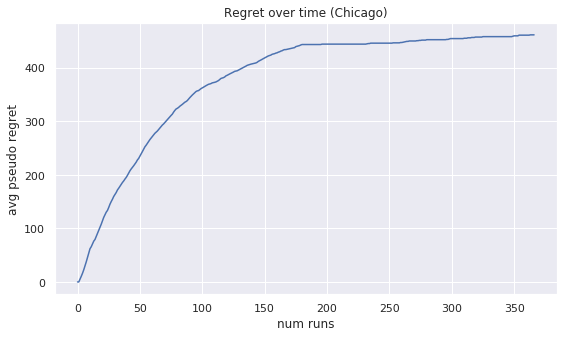

In [22]:
plt.figure(figsize=(9,5))
plt.plot(UCB_pseudo_regret/num_runs)
plt.title('Regret over time (Chicago)')
plt.xlabel('num runs')
plt.ylabel('avg pseudo regret')

Text(0, 0.5, 'avg num pulls')

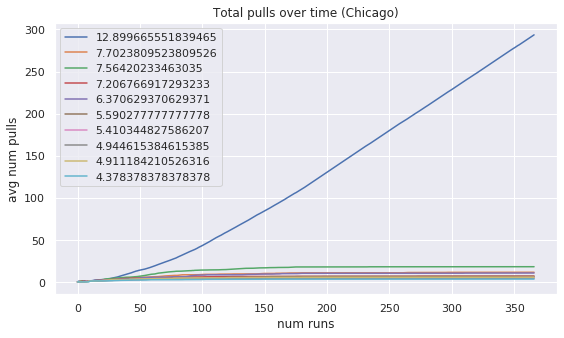

In [23]:
plt.figure(figsize=(9,5))
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[0], label=means[0])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[1], label=means[1])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[2], label=means[2])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[3], label=means[3])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[4], label=means[4])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[5], label=means[5])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[6], label=means[6])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[7], label=means[7])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[8], label=means[8])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[9], label=means[9])
plt.legend()
plt.title('Total pulls over time (Chicago)')
plt.xlabel('num runs')
plt.ylabel('avg num pulls')

Text(0, 0.5, 'avg reward')

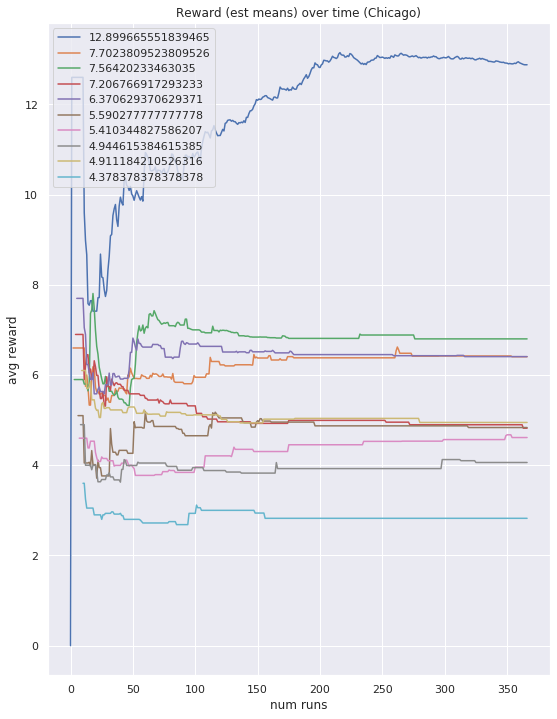

In [24]:
plt.figure(figsize=(9,12))
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[0], label=means[0])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[1], label=means[1])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[2], label=means[2])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[3], label=means[3])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[4], label=means[4])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[5], label=means[5])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[6], label=means[6])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[7], label=means[7])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[8], label=means[8])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[9], label=means[9])
plt.legend()
plt.title('Reward (est means) over time (Chicago)')
plt.xlabel('num runs')
plt.ylabel('avg reward')

Text(0, 0.5, 'avg conf bound')

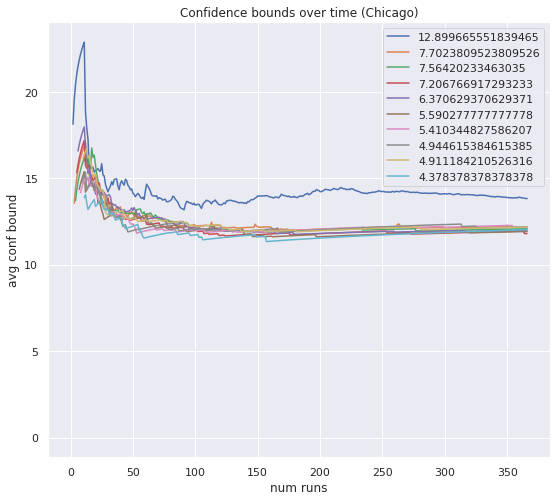

In [25]:
plt.figure(figsize=(9,8))
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[0], label=means[0])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[1], label=means[1])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[2], label=means[2])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[3], label=means[3])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[4], label=means[4])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[5], label=means[5])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[6], label=means[6])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[7], label=means[7])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[8], label=means[8])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[9], label=means[9])
plt.legend()
plt.title('Confidence bounds over time (Chicago)')
plt.xlabel('num runs')
plt.ylabel('avg conf bound')

In [26]:
means=dc_merged.groupby('station_id').agg(np.mean).sort_values('total_count', ascending=False).iloc[:10]['total_count'].values
variance= 8
standard_deviations= [np.sqrt(variance) for arm in range(len(means))]
bandit_env=BanditEnv(dc_merged, dc_top_ten, means, standard_deviations)

In [27]:
T=len(dc_merged.groupby('by_day').agg('count'))
num_runs=10

UCB_pseudo_regret=0

army = []
total_pulls = []
rews = []
bounds = []


for runs in range(num_runs):
    bandit_env.initialize(make_plot=0)
    soldier = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]
    one_pullup = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]
    rew_by_arm = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]
    bound_by_arm = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]
    for t in range(1,T+1):
        arm,confidence_bounds=UCB_pull_arm(t,variance,bandit_env.times_pulled,bandit_env.rewards)
        bandit_env.pull_arm(arm)
        soldier[arm].append(arm)
        for i in np.arange(10):
            rew_by_arm[i].append(np.mean(bandit_env.rewards[i]))
            bound_by_arm[i].append(confidence_bounds[i])
            if arm == i:
                one_pullup[arm].append(one_pullup[arm][len(one_pullup[arm]) - 1] + 1)
            else:
                one_pullup[i].append(one_pullup[i][len(one_pullup[i]) - 1])
    
    army.append(soldier)
    total_pulls.append(one_pullup)
    rews.append(rew_by_arm)
    bounds.append(bound_by_arm)
    UCB_pseudo_regret+=np.array(bandit_env.regret)

Text(0, 0.5, 'avg pseudo regret')

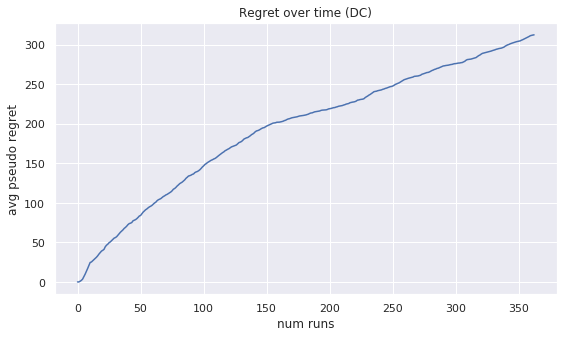

In [28]:
plt.figure(figsize=(9,5))
plt.plot(UCB_pseudo_regret/num_runs)
plt.title('Regret over time (DC)')
plt.xlabel('num runs')
plt.ylabel('avg pseudo regret')

Text(0, 0.5, 'avg num pulls')

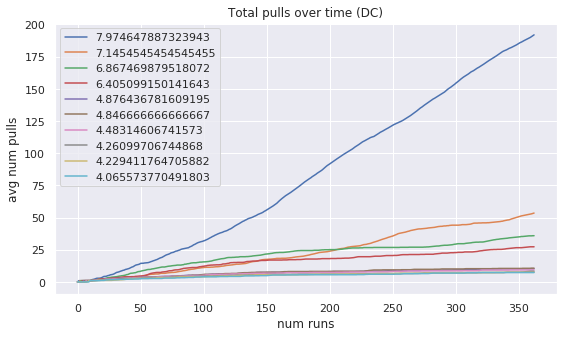

In [29]:
plt.figure(figsize=(9,5))
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[0], label=means[0])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[1], label=means[1])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[2], label=means[2])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[3], label=means[3])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[4], label=means[4])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[5], label=means[5])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[6], label=means[6])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[7], label=means[7])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[8], label=means[8])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[9], label=means[9])
plt.legend()
plt.title('Total pulls over time (DC)')
plt.xlabel('num runs')
plt.ylabel('avg num pulls')

Text(0, 0.5, 'avg reward')

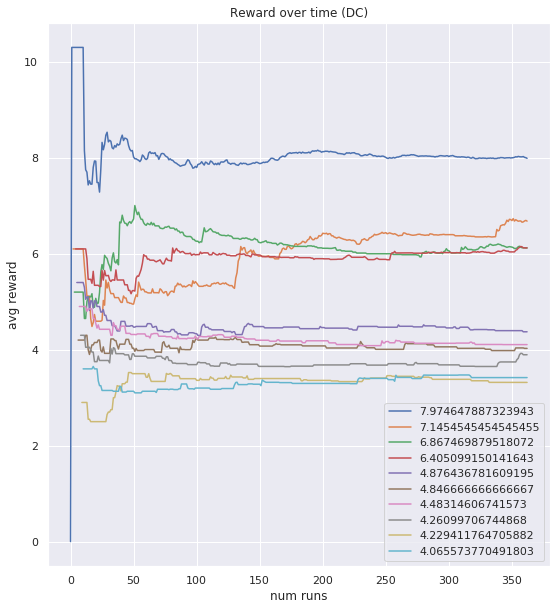

In [30]:
plt.figure(figsize=(9,10))
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[0], label=means[0])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[1], label=means[1])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[2], label=means[2])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[3], label=means[3])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[4], label=means[4])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[5], label=means[5])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[6], label=means[6])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[7], label=means[7])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[8], label=means[8])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[9], label=means[9])
plt.legend()
plt.title('Reward over time (DC)')
plt.xlabel('num runs')
plt.ylabel('avg reward')

Text(0, 0.5, 'avg conf bound')

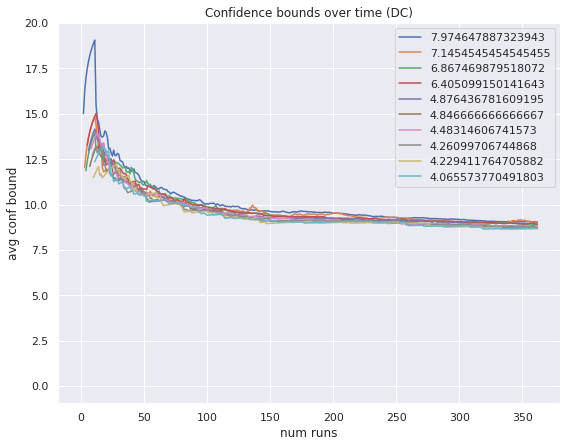

In [31]:
plt.figure(figsize=(9,7))
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[0], label=means[0])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[1], label=means[1])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[2], label=means[2])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[3], label=means[3])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[4], label=means[4])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[5], label=means[5])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[6], label=means[6])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[7], label=means[7])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[8], label=means[8])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[9], label=means[9])
plt.legend()
plt.title('Confidence bounds over time (DC)')
plt.xlabel('num runs')
plt.ylabel('avg conf bound')

In [32]:
means=ny_merged.groupby('station_id').agg(np.mean).sort_values('total_count', ascending=False).iloc[:10]['total_count'].values
variance= 8
standard_deviations= [np.sqrt(variance) for arm in range(len(means))]
bandit_env=BanditEnv(ny_merged, ny_top_ten, means,standard_deviations)

In [33]:
T=len(ny_merged.groupby('by_day').agg('count'))
num_runs=10

UCB_pseudo_regret=0

army = []
total_pulls = []
rews = []
bounds = []


for runs in range(num_runs):
    bandit_env.initialize(make_plot=0)
    soldier = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]
    one_pullup = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]
    rew_by_arm = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]
    bound_by_arm = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]
    for t in range(1,T+1):
        arm,confidence_bounds=UCB_pull_arm(t,variance,bandit_env.times_pulled,bandit_env.rewards)
        bandit_env.pull_arm(arm)
        soldier[arm].append(arm)
        for i in np.arange(10):
            rew_by_arm[i].append(np.mean(bandit_env.rewards[i]))
            bound_by_arm[i].append(confidence_bounds[i])
            if arm == i:
                one_pullup[arm].append(one_pullup[arm][len(one_pullup[arm]) - 1] + 1)
            else:
                one_pullup[i].append(one_pullup[i][len(one_pullup[i]) - 1])
    
    army.append(soldier)
    total_pulls.append(one_pullup)
    rews.append(rew_by_arm)
    bounds.append(bound_by_arm)
    UCB_pseudo_regret+=np.array(bandit_env.regret)

Text(0, 0.5, 'avg pseudo regret')

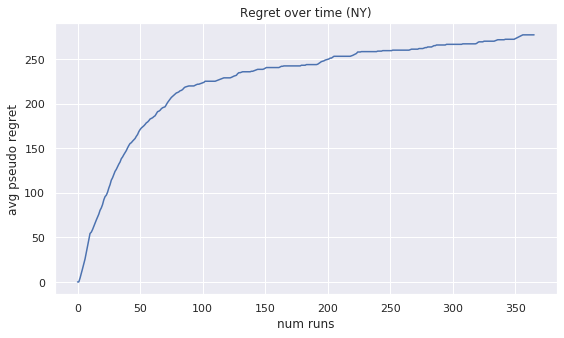

In [34]:
plt.figure(figsize=(9,5))
plt.plot(UCB_pseudo_regret/num_runs)
plt.title('Regret over time (NY)')
plt.xlabel('num runs')
plt.ylabel('avg pseudo regret')

Text(0, 0.5, 'avg num pulls')

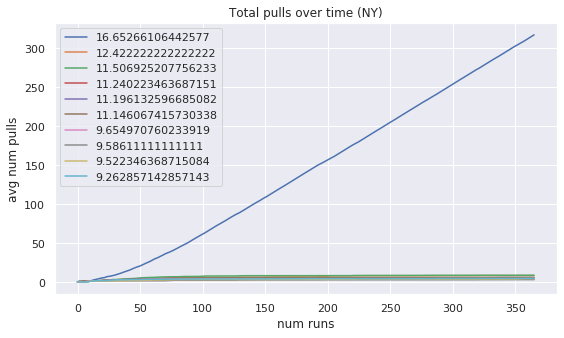

In [35]:
plt.figure(figsize=(9,5))
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[0], label=means[0])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[1], label=means[1])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[2], label=means[2])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[3], label=means[3])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[4], label=means[4])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[5], label=means[5])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[6], label=means[6])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[7], label=means[7])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[8], label=means[8])
plt.plot(np.arange(T+1), np.mean(np.array(total_pulls), axis=0)[9], label=means[9])
plt.legend()
plt.title('Total pulls over time (NY)')
plt.xlabel('num runs')
plt.ylabel('avg num pulls')

Text(0, 0.5, 'avg reward')

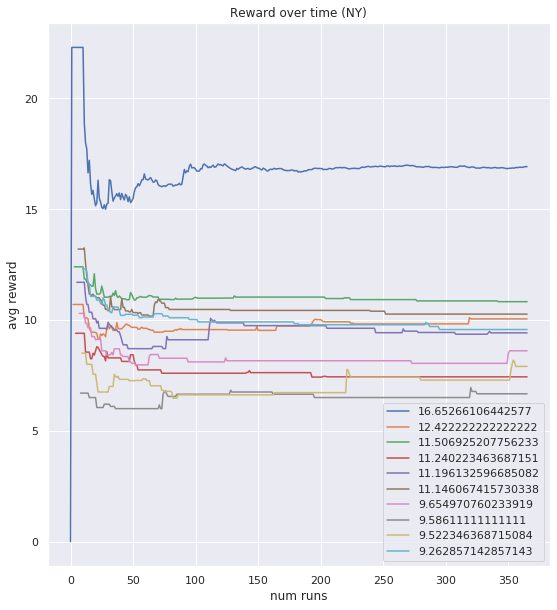

In [36]:
plt.figure(figsize=(9,10))
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[0], label=means[0])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[1], label=means[1])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[2], label=means[2])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[3], label=means[3])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[4], label=means[4])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[5], label=means[5])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[6], label=means[6])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[7], label=means[7])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[8], label=means[8])
plt.plot(np.arange(T+1), np.mean(np.array(rews), axis=0)[9], label=means[9])
plt.legend()
plt.title('Reward over time (NY)')
plt.xlabel('num runs')
plt.ylabel('avg reward')

Text(0, 0.5, 'avg conf bound')

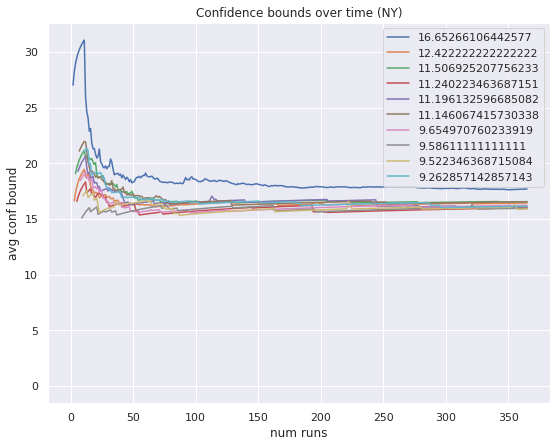

In [37]:
plt.figure(figsize=(9,7))
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[0], label=means[0])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[1], label=means[1])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[2], label=means[2])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[3], label=means[3])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[4], label=means[4])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[5], label=means[5])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[6], label=means[6])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[7], label=means[7])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[8], label=means[8])
plt.plot(np.arange(T+1), np.mean(np.array(bounds), axis=0)[9], label=means[9])
plt.legend()
plt.title('Confidence bounds over time (NY)')
plt.xlabel('num runs')
plt.ylabel('avg conf bound')

#### Simulation Description

I used the top ten stations in each city as arms, using the means of total riders observed at each of the ten stations. I chose a variance of 11, as it was not high enough to make the pseudo-regret behave linearly.  

I modified the bandit environment provided in Lab8, in order to choose the reward based on the counts found in the dataset. Therefore, when an arm is pulled, instead of sampling from a Gaussian to determine the reward, I instead chose a count of riders from that station, which was the arm pulled. This caused the rewards to be bounded by the minimum and maximum values of the count of riders in the dataset.

Then, I defined the upper confidence bound with the same formula provided in Lab8. The derived bound needs an assumption of Gaussian random variables, but because bounded random variables are sub-Gaussian random variables, I proceeded with the assumption.

I defined the time horizon as all the days (of the year) represented in the dataset for that city. I then instantiated a variable to keep track of pseudo regret and 4 lists to keep track of which arm was being pulled, the accumulated number of pulls per arm, the accumulation of the rewards per arm, and the upper confidence bounds per arm. I would use these later to average over all the runs of the algorithm.

Then, for each run of the algorithm, I made another 4 lists of 10 individual lists, for the 4 purposes defined above, in order to keep track of the counts over time for each arm. I ran the UCB algorithm throughout the defined time period, tracking which arm was pulled along the way. For each time step, I cycled through all the arms to accrue the mean of the rewards gained by that arm in that run, the upper confidence bound as determined by the algorithm on that run, and kept a running tally of the pulls each arm received.

For each city, I plotted the pseudo regret over time, by averaging pseudo regret over the number of runs. I then plotted the total number of pulls per arm, by averaging total pulls per arm over all the runs of the algorithm. I then repeated the process for the mean of the rewards, and the upper confidence bounds.

### 1.2.2 Discussion

Yes, the results of the simulation would change over different orderings of the arms pulled. This is because of the randomness with which the rewards are chosen, since the reward (the count of riders) is chosen from the station (arm) pulled, but with a random choice of the day.

I think you could also take into account the other factors present in the dataset, such as gender and birth year. From the previous part of the project, visualizations show there are more male riders than female riders, and most of them are born in the late 1980s to early 1990s. Therefore, if these features were taken into account, I could send the employee to the station with the highest concentration of male riders born in that time frame.

## 1.3 Takeaways

It is suitable for addressing the question, because theoretically, posting your employee at the busiest intersection should yield the highest reward. The simulation supports that, as the station that is the busiest (with the highest average daily mean) for all 3 cities is visited the most, and has the highest average reward over time. However, it is lacking because there is the assumption that just because these customers ride bikes, they will also want to ride scooters, and that by flyering to them, we will receive their business. Because the reward is modeled as the count of riders and not the people that sign up because of the promotion, there is that caveat.

The multi-armed bandits formulation applies because there are many intersections, but only one employee, so learning from previously gathered data, the algorithm will choose to send that employee to the busiest station each time, instead of exploring the other stations. The assumption of truly random rewards is violated by limiting the rewards to just be the observed counts of people at the station.

I would recommend using UCB to adaptively place the employee, but I would suggest modifying it to target the gender and age group that the company should be trying to target (males born in 1980s/1990s), as evidenced by the distributions of gender and age in the previous part of the project. The simulation performs quite well already, by always choosing the busiest station, it always guarantees a higher reward than the other possible stations, but could be improved by doing so. 

# 2 Privacy Concerns

## 2.1 Exploratory Analysis

In [38]:
leaked_table.head()

,name,sex,zip,month,year
0,Avery Phillips,M,94709,3,1993
1,Grayson Rodriguez,M,94705,6,1998
2,Ethan Baker,M,94712,1,1998
3,Carter Wright,M,94720,7,1995
4,Elijah Young,M,94706,2,1996


Text(0.5, 1.0, 'Number of Males and Females')

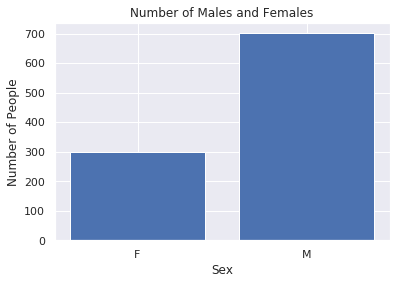

In [39]:
leaked_sex = leaked_table.groupby('sex').agg('count')
plt.bar(leaked_sex.index, leaked_sex['name'])
plt.xlabel('Sex')
plt.ylabel('Number of People')
plt.title('Number of Males and Females')

Text(0.5, 1.0, 'Distribution of Birth Months')

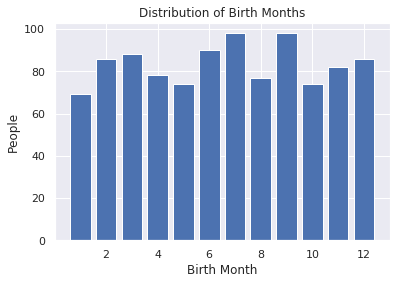

In [40]:
leaked_month = leaked_table.groupby('month').agg('count')
plt.bar(leaked_month.index, leaked_month['name'])
plt.xlabel('Birth Month')
plt.ylabel('People')
plt.title('Distribution of Birth Months')

Text(0.5, 1.0, 'Distribution of Birth Years')

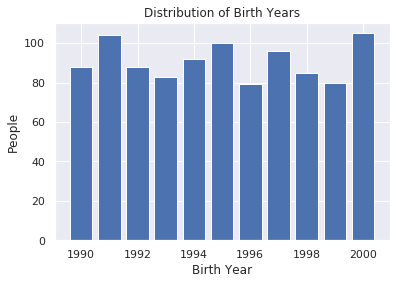

In [41]:
leaked_year = leaked_table.groupby('year').agg('count')
plt.bar(leaked_year.index, leaked_year['name'])
plt.xlabel('Birth Year')
plt.ylabel('People')
plt.title('Distribution of Birth Years')

The number of males and females is not uniformly distributed, but the birth months and birth years are somewhat uniformly distributed. This is different from the distributions from part 1 of the project, where the birth years were not uniformly distributed, and instead, quite left-skewed.

## 2.2 Simple Proof of Concept

In [42]:
leaked_iden = leaked_table.groupby(['sex', 'month', 'year']).agg('count')
identif = leaked_iden[leaked_iden['name'] == 1]

In [43]:
identif['name'].sum()

43

Text(0.5, 1.0, 'Number of Males and Females, Identifiable Users')

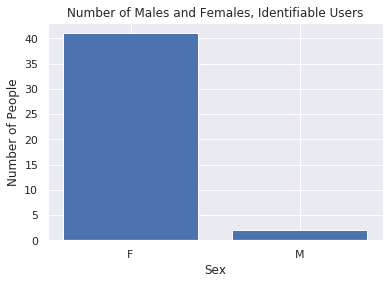

In [44]:
leaked_iden_sex = identif.groupby('sex').agg('count')
plt.bar(leaked_iden_sex.index, leaked_iden_sex['name'])
plt.xlabel('Sex')
plt.ylabel('Number of People')
plt.title('Number of Males and Females, Identifiable Users')

Text(0.5, 1.0, 'Distribution of Birth Months')

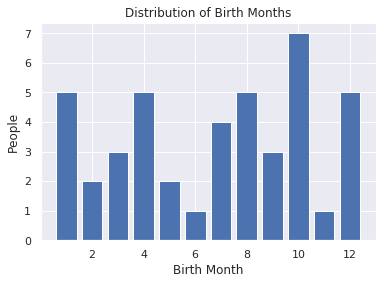

In [45]:
leaked_iden_month = identif.groupby('month').agg('count')
plt.bar(leaked_iden_month.index, leaked_iden_month['name'], align='center')
plt.xlabel('Birth Month')
plt.ylabel('People')
plt.title('Distribution of Birth Months')

Text(0.5, 1.0, 'Distribution of Birth Years')

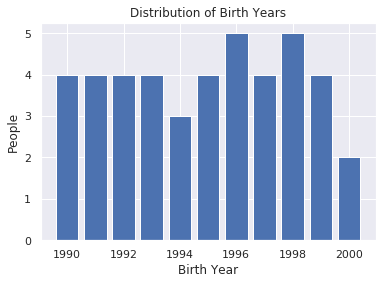

In [46]:
leaked_iden_year = identif.groupby('year').agg('count')
plt.bar(leaked_iden_year.index, leaked_iden_year['name'])
plt.xlabel('Birth Year')
plt.ylabel('People')
plt.title('Distribution of Birth Years')

In [47]:
def find_identity(x):
    finding = leaked_table[leaked_table['sex'] == x[0]]
    finding = finding[finding['month'] == x[1]]
    finding = finding[finding['year'] == x[2]]
    return finding

In [48]:
identif['index'] = identif.index

/srv/conda/envs/data102/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
find_identity(identif.index[0])

,name,sex,zip,month,year
849,Mia Perez,F,94705,1,1991


In [50]:
identities = pd.DataFrame()
for i in np.arange(len(identif.index)):
    identities = identities.append(find_identity(identif.index[i]))

In [51]:
identities.head()

,name,sex,zip,month,year
849,Mia Perez,F,94705,1,1991
757,Ella Lee,F,94710,1,1992
25,Emily Phillips,F,94702,1,1995
759,Amelia Clark,F,94709,1,1998
146,Abigail King,F,94703,1,1999


In [52]:
id_and_rentals = identities.merge(berkeley_table, how = 'left', on = ['sex', 'month', 'year'])
id_and_rentals.head()

,name,sex,zip,month,year,start,end
0,Mia Perez,F,94705,1,1991,94705,94705
1,Mia Perez,F,94705,1,1991,94701,94705
2,Mia Perez,F,94705,1,1991,94705,94705
3,Mia Perez,F,94705,1,1991,94705,94708
4,Mia Perez,F,94705,1,1991,94705,94702


43 users can be isolated based on just those three attributes.<br><br>
The distribution of males and females does not match the corresponding distribution in 2.1. In fact, it reflects the opposite, with many more females than males, whereas in 2.1, there were significantly more males. It does not match because more females had their information leaked than males. <br><br>
The distribution of birth months varies much more than the corresponding distribution in 2.1. This is mostly likely because there are less people in the uniquely identifiable dataset, they are more likely to be born in differing months.

## 2.3 A More Elaborate Attack

MLE estimate for bernoulli is just sample mean

In [53]:
# 1 is not starting from same place
p1 = np.mean(id_and_rentals['zip'] != id_and_rentals['start'])

# 1 is not ending in same place
p2 = np.mean(id_and_rentals['zip'] != id_and_rentals['end'])

p1, p2

(0.09659863945578231, 0.2780045351473923)

In [54]:
p1_arr = []
p2_arr = []

for i in np.arange(1000):
    samp = id_and_rentals.sample(len(id_and_rentals), replace=True)
    samp_p1 = np.mean(samp['zip'] != samp['start'])
    samp_p2 = np.mean(samp['zip'] != samp['end'])
    p1_arr.append(samp_p1)
    p2_arr.append(samp_p2)

In [55]:
np.percentile(p1_arr, 2.5), np.percentile(p1_arr, 97.5)

(0.08435374149659863, 0.10839002267573696)

In [56]:
np.percentile(p2_arr, 2.5), np.percentile(p2_arr, 97.5)

(0.2589569160997732, 0.2984126984126984)

In [57]:
theoret_iden = leaked_table.groupby(['sex', 'zip', 'month', 'year']).agg('count')
theo_iden_users = theoret_iden[theoret_iden['name'] == 1]
len(theo_iden_users)

720

There are 720 theoretically identifiable users.

In [58]:
def find_identity_2(x):
    finding = leaked_table[leaked_table['sex'] == x[0]]
    finding = finding[finding['zip'] == x[1]]
    finding = finding[finding['month'] == x[2]]
    finding = finding[finding['year'] == x[3]]
    return finding

In [59]:
theo_idens = pd.DataFrame()
for i in np.arange(len(theo_iden_users.index)):
    theo_idens = theo_idens.append(find_identity_2(theo_iden_users.index[i]))

In [60]:
smpl = berkeley_table.iloc[31:32]
smpl

,sex,month,year,start,end
31,M,5,1996,94702,94702


In [61]:
fd = theo_idens[theo_idens['sex'] == smpl['sex'].iloc[0]]
fd = fd[fd['month'] == smpl['month'].iloc[0]]
fd = fd[fd['year'] == smpl['year'].iloc[0]]
fd

,name,sex,zip,month,year
765,Dylan Clark,M,94702,5,1996
910,Grayson Lopez,M,94703,5,1996
102,Matthew Anderson,M,94709,5,1996


In [62]:
probs = []
for i, row in fd.iterrows():
    if row['zip'] != smpl['start'].iloc[0]:
        fin_p = p1
    elif row['zip'] != smpl['end'].iloc[0]:
        fin_p = p2
    else:
        fin_p = 1 - (p1 + p2)
    probs.append(fin_p)

In [63]:
probs

[0.6253968253968254, 0.09659863945578231, 0.09659863945578231]

In [64]:
fd['name'].iloc[probs.index(np.max(probs))]

'Dylan Clark'

In [65]:
def find_that_user(row):
    fd = theo_idens[theo_idens['sex'] == smpl['sex'].iloc[0]]
    fd = fd[fd['month'] == smpl['month'].iloc[0]]
    fd = fd[fd['year'] == smpl['year'].iloc[0]]

    probs = []
    for i, row in fd.iterrows():
        if row['zip'] != smpl['start'].iloc[0]:
            fin_p = p1
        elif row['zip'] != smpl['end'].iloc[0]:
            fin_p = p2
        else:
            fin_p = 1 - (p1 + p2)
        probs.append(fin_p)
    return fd['name'].iloc[probs.index(np.max(probs))]

In [66]:
find_that_user(smpl)

'Dylan Clark'

## 2.4 Takeaways

Even though the released data seemed anonymous, there were still a number of people who could have had their identity compromised, because they and their rental history were identifiable by the information provided. The actual identifiable users was 43, but in theory, up to 720 people could have had their identities compromised. Interestingly, even though more of the overall users were male, the leaked users were majority female.

The identifiable users' information should be removed from the already released data, so that at least their information will no longer be out there. So anyone with criteria with the 3 or 4 features that isolates them should be removed from the dataset. It would be difficult to release future datasets that are still useful but less susceptible to privacy failure, because key information in both utility and identification is the zip code of the person and the rentals. However, perhaps the privacy failure could be mitigated by leaving out the birth month, since it does not provide much useful information.